<a href="https://colab.research.google.com/github/Rupesh1919/ML/blob/main/MLPB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!tar -xzvf "/content/sample_data/UTKFace.tar.gz"

Streaming output truncated to the last 5000 lines.
UTKFace/33_1_0_20170111182452825.jpg.chip.jpg
UTKFace/26_1_1_20170116024053194.jpg.chip.jpg
UTKFace/25_1_0_20170109213232182.jpg.chip.jpg
UTKFace/28_1_1_20170112234526480.jpg.chip.jpg
UTKFace/57_0_0_20170117191704100.jpg.chip.jpg
UTKFace/27_1_1_20170117193211345.jpg.chip.jpg
UTKFace/46_1_1_20170116161237892.jpg.chip.jpg
UTKFace/24_0_2_20170116171647508.jpg.chip.jpg
UTKFace/42_1_1_20170113005712902.jpg.chip.jpg
UTKFace/25_1_1_20170116001337504.jpg.chip.jpg
UTKFace/40_1_0_20170116222110661.jpg.chip.jpg
UTKFace/50_1_0_20170109012257664.jpg.chip.jpg
UTKFace/26_1_3_20170104235421282.jpg.chip.jpg
UTKFace/7_0_0_20170110215711115.jpg.chip.jpg
UTKFace/1_1_2_20161219155353413.jpg.chip.jpg
UTKFace/26_0_1_20170117195651493.jpg.chip.jpg
UTKFace/7_0_0_20170110215648859.jpg.chip.jpg
UTKFace/64_0_0_20170117155540137.jpg.chip.jpg
UTKFace/48_0_0_20170109004813150.jpg.chip.jpg
UTKFace/39_0_0_20170103183230555.jpg.chip.jpg
UTKFace/45_0_1_20170117190019363

In [ ]:
dataset_folder_name = '/content/UTKFace'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [ ]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [ ]:
df = parse_dataset(dataset_folder_name)
df.head()

,age,gender,race,file
0,48.0,male,white,/content/UTKFace/48_0_0_20170117174428789.jpg....
1,68.0,female,white,/content/UTKFace/68_1_0_20170110155156093.jpg....
2,24.0,female,white,/content/UTKFace/24_1_0_20170117150524692.jpg....
3,30.0,female,indian,/content/UTKFace/30_1_3_20170119204037590.jpg....
4,36.0,male,white,/content/UTKFace/36_0_0_20170117203443991.jpg....


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from PIL import Image

class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])

        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [ ]:
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
#from keras.layers.normalization import BatchNormalization
#from keras.layers.convolutional import Conv2D
#from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = layers.Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = layers.BatchNormalization(axis=-1)(x)
        x = layers.MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = layers.Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = layers.BatchNormalization(axis=-1)(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = layers.Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = layers.BatchNormalization(axis=-1)(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x

    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = layers.BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)

        return x

    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = layers.BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.

        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = layers.BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height, num_races):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")

        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))

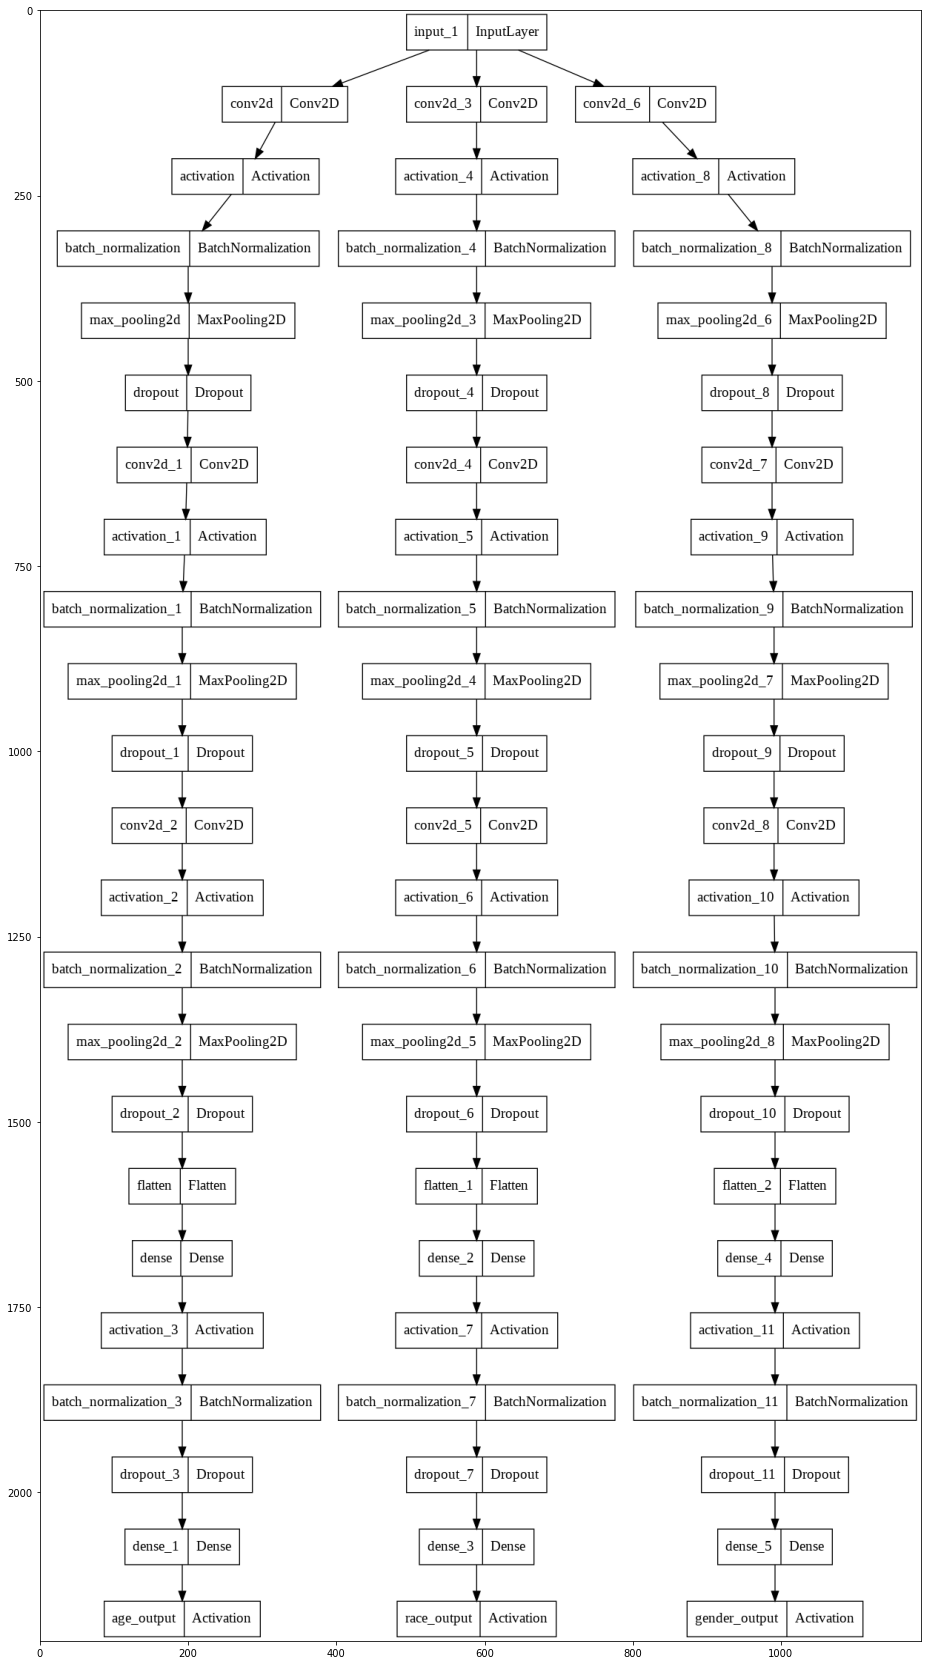

In [ ]:
%matplotlib inline

from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plot_model(model, to_file='model.png')
img = mpimg.imread('model.png')

plt.figure(figsize=(40, 30))
plt.imshow(img)

In [ ]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 198, 198, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 198, 198, 16  448         ['input_1[0][0]']                
                                )                                                          

In [ ]:
from tensorflow.keras.optimizers import Adam

init_lr = 1e-4
epochs = 2

opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'race_output': 1.5, 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
362/362 [==============================] - 1287s 4s/step - loss: 12.6159 - age_output_loss: 2.4662 - race_output_loss: 1.7888 - gender_output_loss: 0.6777 - age_output_mae: 1.2226 - race_output_accuracy: 0.4227 - gender_output_accuracy: 0.7209 - val_loss: 14.7169 - val_age_output_loss: 2.2603 - val_race_output_loss: 3.7286 - val_gender_output_loss: 0.8258 - val_age_output_mae: 1.2898 - val_race_output_accuracy: 0.4337 - val_gender_output_accuracy: 0.5954
Epoch 2/2
362/362 [==============================] - 1227s 3s/step - loss: 8.3101 - age_output_loss: 1.5650 - race_output_loss: 1.3331 - gender_output_loss: 0.5030 - age_output_mae: 0.9576 - race_output_accuracy: 0.5406 - gender_output_accuracy: 0.7986 - val_loss: 19.3934 - val_age_output_loss: 3.9220 - val_race_output_loss: 2.4189 - val_gender_output_loss: 0.7719 - val_age_output_mae: 1.1706 - val_race_output_accuracy: 0.5139 - val_gender_output_accuracy: 0.7536


In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['race_output_acc'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_race_output_acc'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Accuracy for race feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_race.html', include_plotlyjs='cdn')

fig.show()

In [ ]:
plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gender_output_acc'],
                    name='Train'))

fig.add_trace(go.Scatter(
                    y=history.history['val_gender_output_acc'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Accuracy for gender feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_gender.html', include_plotlyjs='cdn')

fig.show()

In [ ]:
plt.clf()

fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['age_output_mean_absolute_error'],
                    name='Train'))

fig.add_trace(go.Scattergl(
                    y=history.history['val_age_output_mean_absolute_error'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Mean Absolute Error for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')

fig.write_html('mae_age.html', include_plotlyjs='cdn')

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scattergl(
                    y=history.history['val_loss'],
                    name='Valid'))


fig.update_layout(height=450, 
                  width=600,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')

fig.write_html('overall_loss.html', include_plotlyjs='cdn')

fig.show()

In [ ]:
test_batch_size = 128
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, race_pred, gender_pred = model.predict_generator(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


In [ ]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, race_true, gender_true = [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])
    
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age

In [ ]:
from sklearn.metrics import classification_report

cr_race = classification_report(race_true, race_pred, target_names=dataset_dict['race_alias'].keys())
print(cr_race)

In [ ]:
cr_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

In [ ]:
from sklearn.metrics import r2_score

print('R2 score for age: ', r2_score(age_true, age_pred))

In [ ]:
age_true

array([29.,  1., 25., ..., 27., 35., 24.])

In [ ]:
for i in range(len(age_pred)):
  if(age_pred[i]<17):
    age_pred[i]=0
  elif(age_pred[i]<34):
    age_pred[i]=1
  elif(age_pred[i]<51):
    age_pred[i]=2
  elif(age_pred[i]<68):
    age_pred[i]=3
  elif(age_pred[i]<85):
    age_pred[i]=4
  elif(age_pred[i]<102):
    age_pred[i]=5
  elif(age_pred[i]<119):
    age_pred[i]=6

In [ ]:
age_pred

array([[0.],
       [2.],
       [0.],
       ...,
       [0.],
       [0.],
       [2.]], dtype=float32)

In [ ]:
for i in range(len(age_true)):
  if(age_true[i]<17):
    age_true[i]=0
  elif(age_true[i]<34):
    age_true[i]=1
  elif(age_true[i]<51):
    age_true[i]=2
  elif(age_true[i]<68):
    age_true[i]=3
  elif(age_true[i]<85):
    age_true[i]=4
  elif(age_true[i]<102):
    age_true[i]=5
  elif(age_true[i]<119):
    age_true[i]=6

age_true

array([1., 0., 1., ..., 1., 2., 1.])

In [ ]:
dataframe_predict=pd.DataFrame()
dataframe_predict['gender']=(gender_pred)
dataframe_predict['race']=race_pred
dataframe_predict['age']=age_pred

In [ ]:
dataframe_predict.head()

,gender,race,age
0,0,0,0.0
1,1,1,2.0
2,1,0,0.0
3,0,0,2.0
4,1,0,0.0


In [ ]:
dataframe_true=pd.DataFrame()
dataframe_true['gender']=gender_true
dataframe_true['race']=race_true
dataframe_true['age']=age_true

In [ ]:
dataframe_true.head(10)

,gender,race,age
0,0,0,1.0
1,1,3,0.0
2,1,2,1.0
3,0,0,2.0
4,1,1,2.0
5,0,2,1.0
6,1,1,2.0
7,0,0,2.0
8,1,2,0.0
9,0,0,2.0


In [ ]:
bucket_dict={}
i=1
sum=0
gender_input_class=[0,1]
race_input_class=[0,1,2,3,4]
age_input_class=[0,1,2,3,4,5,6]
for i in range(len(gender_input_class)):
  for j in range(len(race_input_class)):
    for k in range(len(age_input_class)):
      sum=sum+1
      bucket_dict[str(gender_input_class[i])+str(race_input_class[j])+str(age_input_class[k])]=sum


In [ ]:
bucket_dict

{'000': 1,
 '001': 2,
 '002': 3,
 '003': 4,
 '004': 5,
 '005': 6,
 '006': 7,
 '010': 8,
 '011': 9,
 '012': 10,
 '013': 11,
 '014': 12,
 '015': 13,
 '016': 14,
 '020': 15,
 '021': 16,
 '022': 17,
 '023': 18,
 '024': 19,
 '025': 20,
 '026': 21,
 '030': 22,
 '031': 23,
 '032': 24,
 '033': 25,
 '034': 26,
 '035': 27,
 '036': 28,
 '040': 29,
 '041': 30,
 '042': 31,
 '043': 32,
 '044': 33,
 '045': 34,
 '046': 35,
 '100': 36,
 '101': 37,
 '102': 38,
 '103': 39,
 '104': 40,
 '105': 41,
 '106': 42,
 '110': 43,
 '111': 44,
 '112': 45,
 '113': 46,
 '114': 47,
 '115': 48,
 '116': 49,
 '120': 50,
 '121': 51,
 '122': 52,
 '123': 53,
 '124': 54,
 '125': 55,
 '126': 56,
 '130': 57,
 '131': 58,
 '132': 59,
 '133': 60,
 '134': 61,
 '135': 62,
 '136': 63,
 '140': 64,
 '141': 65,
 '142': 66,
 '143': 67,
 '144': 68,
 '145': 69,
 '146': 70}

In [ ]:
def distance(i):
  count=0
  if dataframe_true['gender'][i]!=dataframe_predict['gender'][i]:
    count=35+(dataframe_true['race'][i]-1)*5+ dataframe_true['age'][i]
  elif(dataframe_true['race'][i]!=dataframe_predict['race'][i]):
    if(dataframe_true['race'][i]>dataframe_predict['race'][i]):
      count=(dataframe_true['race'][i]-1)*6+ dataframe_true['age'][i]+5
    else:
      count=(dataframe_true['race'][i]-1)*6+ dataframe_true['age'][i]   
  elif(dataframe_true['age'][i]!=dataframe_predict['age'][i]):
    if(dataframe_true['age'][i]>dataframe_predict['age'][i]):
      count=dataframe_true['age'][i]
    else:
      count=dataframe_true['age'][i]+1
      
  return count

In [ ]:
distance(0)

1.0

In [ ]:
distance(3)

0

In [ ]:
distance(4)

7.0

In [ ]:

count=35+(dataframe_true['race'][2]-1)*5+ dataframe_true['age'][2]
print(count)

41.0


In [ ]:
cd '/content/UTKFace'

/content/UTKFace


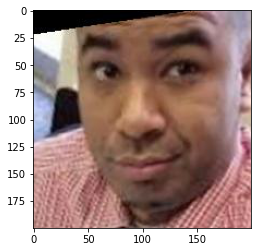

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

IndexError: ignored

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

import glob


# re-size all the images to this
IMAGE_SIZE = [100, 100] 

# training config:
epochs = 5
batch_size = 32
train_path = '/content/UTKFace'
valid_path = '/content/UTKFace/'


image_files = glob.glob(train_path + '/*.jp*g')
valid_image_files = glob.glob(valid_path + '/*.jp*g')
folders = glob.glob(train_path + '/*')


plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False


x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)



#  ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


# testing generator

test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.filenames)
print("test")
print(test_gen.class_indices)
print(test_gen.filenames)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k
print(test_gen)
for x, y in test_gen:
  print(x,y)
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)



def get_confusion_matrix(data_path, N):
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)



# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

import glob


# re-size all the images to this
IMAGE_SIZE = [100, 100] 

# training config:
epochs = 5
batch_size = 32
train_path = '/content/UTKFace'
valid_path = '/content/UTKFace/'


image_files = glob.glob(train_path + '/*.jp*g')
valid_image_files = glob.glob(valid_path + '/*.jp*g')
folders = glob.glob(train_path + '/*')


plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False


x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [ ]:
r = model.fit_generator(
  train_gen,
  validation_data=valid_gen,
  epochs=epochs,
  steps_per_epoch=len(train_idx) // batch_size,
  validation_steps=len(valid_idx) // batch_size,
)